In [2]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from tqdm import tqdm

from datetime import datetime
from pathlib import Path

import params.learning
from params.learning import LEARNING, NET_PARAMS
from stats import compute_mean_std
from dataset import get_sets
from utils.dataset import get_dataloader
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test
from result import generate_log

from params import PROJECT_PATH
from custom_transforms import Cutout

plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare data

In [ ]:
train_set, val_set, test_set = get_sets(
    params.learning.DATASET,
)

train_loader, val_loader, test_loader = get_dataloader(
    train_set, val_set, test_set
)

## Training and validation

In [3]:
model = ResNet18Velocity_Regression_Alt(
    nb_input_channels=NET_PARAMS["nb_input_channels"],
    nb_input_features=NET_PARAMS["nb_input_features"],
    nb_classes=1,
).to(device=device)

In [6]:
criterion_regression = nn.MSELoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING["learning_rate"],
)

scheduler = optim.lr_scheduler.LinearLR(
    optimizer=optimizer, total_iters=LEARNING["nb_epochs"]
)

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING["nb_epochs"])

for epoch in tqdm(range(LEARNING["nb_epochs"])):
    train_regression_loss = train(
        model,
        device,
        train_loader,
        optimizer,
        scheduler,
        criterion_regression,
        epoch,
    )

    val_regression_loss = validate(
        model, device, val_loader, criterion_regression, epoch
    )

    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss

#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  1%|          | 1/100 [00:43<1:12:29, 43.94s/it]

Train regression loss:  1.4439805024775907
Validation regression loss:  1.27230919500192


  2%|▏         | 2/100 [01:30<1:14:08, 45.39s/it]

Train regression loss:  1.2855416113051816
Validation regression loss:  1.2041655520598094


  3%|▎         | 3/100 [02:18<1:15:27, 46.68s/it]

Train regression loss:  1.1968563713025355
Validation regression loss:  1.0701863865057628


  4%|▍         | 4/100 [03:03<1:13:35, 46.00s/it]

Train regression loss:  1.1686581351618837
Validation regression loss:  1.2091829299926757


  5%|▌         | 5/100 [03:49<1:12:32, 45.82s/it]

Train regression loss:  1.1175997823044874
Validation regression loss:  1.0989675343036651


  6%|▌         | 6/100 [04:34<1:11:40, 45.75s/it]

Train regression loss:  1.1107538061729376
Validation regression loss:  1.1186971624692281


  7%|▋         | 7/100 [05:23<1:12:20, 46.67s/it]

Train regression loss:  1.078223896631296
Validation regression loss:  1.2468088646729787


  8%|▊         | 8/100 [06:10<1:11:53, 46.89s/it]

Train regression loss:  1.0662470628385958
Validation regression loss:  1.0605859200159709


  9%|▉         | 9/100 [06:58<1:11:51, 47.37s/it]

Train regression loss:  1.0512516878653264
Validation regression loss:  1.1294986446698507


 10%|█         | 10/100 [07:44<1:10:19, 46.88s/it]

Train regression loss:  1.0287514590266822
Validation regression loss:  0.9885054528713226


 11%|█         | 11/100 [08:31<1:09:20, 46.75s/it]

Train regression loss:  1.0163846119590427
Validation regression loss:  0.950100439786911


 12%|█▏        | 12/100 [09:17<1:08:11, 46.49s/it]

Train regression loss:  1.0154472040957299
Validation regression loss:  1.0208424170811972


 13%|█▎        | 13/100 [10:03<1:07:23, 46.48s/it]

Train regression loss:  1.0064861433229584
Validation regression loss:  1.1103312214215597


 14%|█▍        | 14/100 [10:49<1:06:23, 46.32s/it]

Train regression loss:  0.9964854885702548
Validation regression loss:  1.0859777788321177


 15%|█▌        | 15/100 [11:36<1:06:04, 46.64s/it]

Train regression loss:  0.969167586254037
Validation regression loss:  0.9689941505591074


 16%|█▌        | 16/100 [12:23<1:05:13, 46.59s/it]

Train regression loss:  0.9670811101146366
Validation regression loss:  1.006901534398397


 17%|█▋        | 17/100 [13:08<1:04:01, 46.28s/it]

Train regression loss:  0.9639222073382225
Validation regression loss:  1.3174245615800222


 18%|█▊        | 18/100 [13:54<1:03:02, 46.13s/it]

Train regression loss:  0.950924819794254
Validation regression loss:  0.9239974270264307


 19%|█▉        | 19/100 [14:41<1:02:41, 46.44s/it]

Train regression loss:  0.9472082011077715
Validation regression loss:  1.2342210312684376


 20%|██        | 20/100 [15:29<1:02:26, 46.83s/it]

Train regression loss:  0.9375646090593891
Validation regression loss:  0.9537724117437999


 21%|██        | 21/100 [16:16<1:01:38, 46.81s/it]

Train regression loss:  0.9255119214455286
Validation regression loss:  0.9438912014166514


 22%|██▏       | 22/100 [17:00<59:40, 45.90s/it]  

Train regression loss:  0.9191714009081108
Validation regression loss:  1.0775390088558197


 23%|██▎       | 23/100 [17:45<58:29, 45.58s/it]

Train regression loss:  0.9035749655702839
Validation regression loss:  0.8927620708942413


 24%|██▍       | 24/100 [18:29<57:20, 45.27s/it]

Train regression loss:  0.9012392072573953
Validation regression loss:  1.5514432648817698


 25%|██▌       | 25/100 [19:13<55:57, 44.77s/it]

Train regression loss:  0.8896788298219874
Validation regression loss:  0.8616255740324656


 26%|██▌       | 26/100 [19:57<54:53, 44.51s/it]

Train regression loss:  0.8785323800816052
Validation regression loss:  0.91666239798069


 27%|██▋       | 27/100 [20:41<53:58, 44.36s/it]

Train regression loss:  0.8670495040174844
Validation regression loss:  0.8523445874452591


 28%|██▊       | 28/100 [21:25<53:11, 44.33s/it]

Train regression loss:  0.860547907974409
Validation regression loss:  0.927303260564804


 29%|██▉       | 29/100 [22:09<52:21, 44.25s/it]

Train regression loss:  0.8495178743117098
Validation regression loss:  0.845909450451533


 30%|███       | 30/100 [22:53<51:35, 44.21s/it]

Train regression loss:  0.8597653929306113
Validation regression loss:  0.87373588681221


 31%|███       | 31/100 [23:38<51:15, 44.57s/it]

Train regression loss:  0.8397192205639853
Validation regression loss:  0.8235347012678782


 32%|███▏      | 32/100 [24:23<50:33, 44.61s/it]

Train regression loss:  0.8629507238882176
Validation regression loss:  1.466287189722061


 33%|███▎      | 33/100 [25:08<49:58, 44.76s/it]

Train regression loss:  0.8671929574962975
Validation regression loss:  0.8484613776206971


 34%|███▍      | 34/100 [25:53<49:16, 44.80s/it]

Train regression loss:  0.839937971122023
Validation regression loss:  0.8777268946170806


 35%|███▌      | 35/100 [26:39<48:45, 45.01s/it]

Train regression loss:  0.8312501289706299
Validation regression loss:  0.946932872136434


 36%|███▌      | 36/100 [27:25<48:35, 45.55s/it]

Train regression loss:  0.8441184737544128
Validation regression loss:  1.0279571334520976


 37%|███▋      | 37/100 [28:11<47:50, 45.57s/it]

Train regression loss:  0.8230170499587405
Validation regression loss:  1.000229795773824


 38%|███▊      | 38/100 [28:58<47:28, 45.94s/it]

Train regression loss:  0.8274284663839616
Validation regression loss:  0.8385532667239507


 39%|███▉      | 39/100 [29:43<46:27, 45.70s/it]

Train regression loss:  0.838118676474129
Validation regression loss:  1.1715734442075094


 40%|████      | 40/100 [30:28<45:22, 45.38s/it]

Train regression loss:  0.8451716511145883
Validation regression loss:  1.0779557406902314


 41%|████      | 41/100 [31:12<44:23, 45.15s/it]

Train regression loss:  0.817209274224613
Validation regression loss:  0.8132279694080353


 42%|████▏     | 42/100 [31:57<43:28, 44.97s/it]

Train regression loss:  0.8178410797879316
Validation regression loss:  0.7770035197337468


 43%|████▎     | 43/100 [32:41<42:36, 44.85s/it]

Train regression loss:  0.819237580117972
Validation regression loss:  0.9059442420800526


 44%|████▍     | 44/100 [33:27<41:59, 44.98s/it]

Train regression loss:  0.8219280264515808
Validation regression loss:  0.9125697563091913


 45%|████▌     | 45/100 [34:11<41:03, 44.78s/it]

Train regression loss:  0.805608783511148
Validation regression loss:  0.811830711364746


 46%|████▌     | 46/100 [34:56<40:29, 44.98s/it]

Train regression loss:  0.8177334603624068
Validation regression loss:  0.7597973008950551


 47%|████▋     | 47/100 [35:44<40:28, 45.81s/it]

Train regression loss:  0.7979190757741099
Validation regression loss:  0.8520122408866883


 48%|████▊     | 48/100 [36:34<40:46, 47.05s/it]

Train regression loss:  0.8112511937169061
Validation regression loss:  1.029208731651306


 49%|████▉     | 49/100 [37:23<40:29, 47.64s/it]

Train regression loss:  0.8042312795701234
Validation regression loss:  0.9141004165013631


 50%|█████     | 50/100 [38:08<39:05, 46.91s/it]

Train regression loss:  0.7960133133591085
Validation regression loss:  0.8431239157915116


 51%|█████     | 51/100 [38:54<38:01, 46.57s/it]

Train regression loss:  0.7955670544634694
Validation regression loss:  1.636138492822647


 52%|█████▏    | 52/100 [39:41<37:26, 46.81s/it]

Train regression loss:  0.7962669697792634
Validation regression loss:  1.1530532777309417


 53%|█████▎    | 53/100 [40:28<36:35, 46.71s/it]

Train regression loss:  0.809834789538729
Validation regression loss:  1.4423523366451263


 54%|█████▍    | 54/100 [41:18<36:29, 47.60s/it]

Train regression loss:  0.7866203402695449
Validation regression loss:  0.8346287131309509


 55%|█████▌    | 55/100 [42:05<35:40, 47.56s/it]

Train regression loss:  0.8081816380870515
Validation regression loss:  0.8551343888044357


 56%|█████▌    | 56/100 [42:54<35:12, 48.00s/it]

Train regression loss:  0.788510563796845
Validation regression loss:  0.8517354647318522


 57%|█████▋    | 57/100 [43:45<35:03, 48.92s/it]

Train regression loss:  0.7779919261085815
Validation regression loss:  0.8508365859587987


 58%|█████▊    | 58/100 [44:34<34:10, 48.81s/it]

Train regression loss:  0.7730192425458328
Validation regression loss:  1.0062687754631043


 59%|█████▉    | 59/100 [45:23<33:21, 48.82s/it]

Train regression loss:  0.7896415450866672
Validation regression loss:  0.7860732913017273


 60%|██████    | 60/100 [46:12<32:41, 49.05s/it]

Train regression loss:  0.7786184689704923
Validation regression loss:  0.7910620292027791


 61%|██████    | 61/100 [47:02<32:01, 49.28s/it]

Train regression loss:  0.7829627342846083
Validation regression loss:  0.9823906044165294


 62%|██████▏   | 62/100 [47:50<30:54, 48.80s/it]

Train regression loss:  0.769869333592014
Validation regression loss:  0.8531153758366903


 63%|██████▎   | 63/100 [48:35<29:29, 47.82s/it]

Train regression loss:  0.7669344311175139
Validation regression loss:  1.0076414306958517


 64%|██████▍   | 64/100 [49:20<28:13, 47.05s/it]

Train regression loss:  0.7729770882406096
Validation regression loss:  0.7665670186281204


 65%|██████▌   | 65/100 [50:06<27:14, 46.70s/it]

Train regression loss:  0.7533955409906913
Validation regression loss:  0.8481187075376511


 66%|██████▌   | 66/100 [50:52<26:13, 46.28s/it]

Train regression loss:  0.7595517250938691
Validation regression loss:  1.2038881341616312


 67%|██████▋   | 67/100 [51:38<25:28, 46.33s/it]

Train regression loss:  0.7562897449386292
Validation regression loss:  0.7978887091080348


 68%|██████▊   | 68/100 [52:26<24:57, 46.79s/it]

Train regression loss:  0.7661687848360642
Validation regression loss:  0.8042234639326732


 69%|██████▉   | 69/100 [53:16<24:44, 47.88s/it]

Train regression loss:  0.7554507581652075
Validation regression loss:  0.9157581170399983


 70%|███████   | 70/100 [54:03<23:48, 47.60s/it]

Train regression loss:  0.7493873063636862
Validation regression loss:  0.9236888388792673


 71%|███████   | 71/100 [54:51<23:00, 47.59s/it]

Train regression loss:  0.7463778194741927
Validation regression loss:  0.9179398437341054


 72%|███████▏  | 72/100 [55:42<22:38, 48.52s/it]

Train regression loss:  0.7631187540465507
Validation regression loss:  0.8114867756764094


 73%|███████▎  | 73/100 [56:29<21:45, 48.34s/it]

Train regression loss:  0.7615809609060702
Validation regression loss:  0.8748242308696111


 74%|███████▍  | 74/100 [57:17<20:52, 48.18s/it]

Train regression loss:  0.7753039784189584
Validation regression loss:  0.8880805432796478


 75%|███████▌  | 75/100 [58:05<20:02, 48.10s/it]

Train regression loss:  0.7696514118840729
Validation regression loss:  0.8654131720463435


 76%|███████▌  | 76/100 [58:55<19:24, 48.52s/it]

Train regression loss:  0.7729500745949538
Validation regression loss:  0.9004750112692516


 77%|███████▋  | 77/100 [59:45<18:45, 48.94s/it]

Train regression loss:  0.7427234934723895
Validation regression loss:  0.8393667976061503


 78%|███████▊  | 78/100 [1:00:36<18:15, 49.78s/it]

Train regression loss:  0.7408152375964151
Validation regression loss:  0.8284340143203736


 79%|███████▉  | 79/100 [1:01:27<17:28, 49.93s/it]

Train regression loss:  0.752598328002985
Validation regression loss:  0.7928951650857925


 80%|████████  | 80/100 [1:02:16<16:32, 49.64s/it]

Train regression loss:  0.7529203857200734
Validation regression loss:  0.7702137043078741


 81%|████████  | 81/100 [1:03:06<15:47, 49.87s/it]

Train regression loss:  0.7481217911277992
Validation regression loss:  0.9293716847896576


 82%|████████▏ | 82/100 [1:03:53<14:42, 49.05s/it]

Train regression loss:  0.7360391601704169
Validation regression loss:  0.76056589782238


 83%|████████▎ | 83/100 [1:04:39<13:36, 48.01s/it]

Train regression loss:  0.726323136816854
Validation regression loss:  1.1024101813634237


 84%|████████▍ | 84/100 [1:05:28<12:55, 48.47s/it]

Train regression loss:  0.7549527775550234
Validation regression loss:  0.8080674370129903


 85%|████████▌ | 85/100 [1:06:16<12:02, 48.14s/it]

Train regression loss:  0.7521301063074581
Validation regression loss:  0.9621926128864289


 86%|████████▌ | 86/100 [1:07:03<11:08, 47.77s/it]

Train regression loss:  0.754466540787531
Validation regression loss:  0.9458213309446971


 87%|████████▋ | 87/100 [1:07:49<10:15, 47.34s/it]

Train regression loss:  0.7398153394460678
Validation regression loss:  0.9506716758012772


 88%|████████▊ | 88/100 [1:08:40<09:42, 48.54s/it]

Train regression loss:  0.7394017259711805
Validation regression loss:  0.8197816550731659


 89%|████████▉ | 89/100 [1:09:27<08:46, 47.90s/it]

Train regression loss:  0.7232328389865764
Validation regression loss:  1.0760508875052135


 90%|█████████ | 90/100 [1:10:13<07:53, 47.35s/it]

Train regression loss:  0.7401387432347173
Validation regression loss:  0.8161817153294881


 91%|█████████ | 91/100 [1:11:04<07:16, 48.49s/it]

Train regression loss:  0.7515634419261545
Validation regression loss:  0.9231687208016713


 92%|█████████▏| 92/100 [1:11:52<06:26, 48.32s/it]

Train regression loss:  0.732508786994478
Validation regression loss:  0.8654159208138784


 93%|█████████▎| 93/100 [1:12:40<05:37, 48.22s/it]

Train regression loss:  0.7206077046584392
Validation regression loss:  0.932096337278684


 94%|█████████▍| 94/100 [1:13:29<04:51, 48.54s/it]

Train regression loss:  0.7278072045765062
Validation regression loss:  0.778101165095965


 95%|█████████▌| 95/100 [1:14:18<04:02, 48.56s/it]

Train regression loss:  0.7352585354145023
Validation regression loss:  1.0626448333263396


 96%|█████████▌| 96/100 [1:15:07<03:14, 48.71s/it]

Train regression loss:  0.7492260725601859
Validation regression loss:  0.8947010298569997


 97%|█████████▋| 97/100 [1:15:58<02:28, 49.44s/it]

Train regression loss:  0.7300324617088705
Validation regression loss:  0.7657840430736542


 98%|█████████▊| 98/100 [1:16:49<01:39, 49.91s/it]

Train regression loss:  0.7152689894040426
Validation regression loss:  0.8330105801423391


 99%|█████████▉| 99/100 [1:17:37<00:49, 49.44s/it]

Train regression loss:  0.7273352349150009
Validation regression loss:  0.7994302431742351


100%|██████████| 100/100 [1:18:28<00:00, 47.08s/it]

Train regression loss:  0.7223567822273227
Validation regression loss:  0.7437563220659892


## Testing

#### Testing the model

In [ ]:
test_regression_loss, _ = test(
    model, device, test_loader, criterion_regression
)

print("Regression loss: ", test_regression_loss)

Regression loss:  0.9045342127482097


#### Generate a log directory

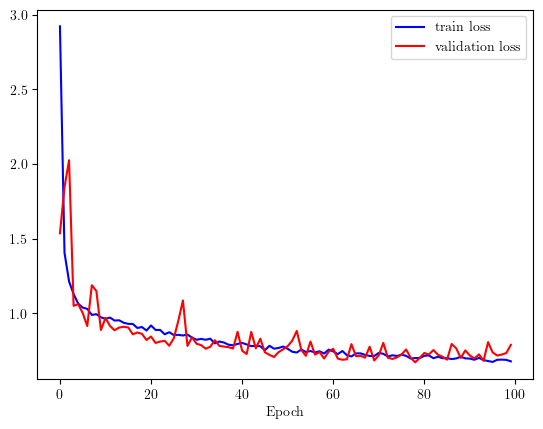

In [ ]:
# Set the path to the results directory
results_directory = Path(
    "logs/_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
)

generate_log(
    results_directory=results_directory,
    test_regression_loss=test_regression_loss,
    parameters_table="",
    model=model,
    regression_loss_values=regression_loss_values,
)